In [ ]:
"""
XÂY DỤNG MÔ HÌNH
 -Mô hình truyền thống (Naive Bayes, Logistic Regression)
 -Mô hình dựa trên mạng nơ-ron(MLPClassifier, Transformer-BERT)
"""

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 125

import seaborn as sns

import pandas as pd
import numpy as np
np.random.seed(0) # Giúp chạy các hàm của scikit-learn giống nhau mỗi lần chạy

import regex as re
import time # Dùng để sleep chương trình
from tqdm.notebook import tqdm # Hiện thanh progress cho đẹp :D
tqdm.pandas()

# Thư viện để request và parse HTML
import requests
from bs4 import BeautifulSoup

# Các thư viện liên quan tới ngôn ngữ và NLP
from pyvi import ViTokenizer # Thư viện NLP tiếng Việt
import gensim
import unicodedata # Thư viện unicode

# Trực quan hóa mô hình dự đoán văn bản
from lime import lime_text

# Dùng để lưu lại model
import pickle

# Thư viện liên quan của Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import feature_selection

# Tạo pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector

# Các mô hình học
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier # Phương pháp bagging

from scipy.sparse import find
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import seaborn as sns

In [76]:
# Thiết lập đường dẫn cho phần 1
dir_1 = "C:/Users/davin/Desktop/KHDL/"
# Thiết lập lại đường dẫn phần 1
dir_1_new = "C:/Users/davin/Desktop/KHDL/raw_data/"
# Thiết lập đường dẫn cho phần 2
dir_2 = "C:/Users/davin/Desktop/KHDL/pre_data/"
# Thiết lập đường dẫn cho phần 3
dir_3 = "C:/Users/davin/Desktop/KHDL/final_data/"
# Thiết lập đường dẫn cho phần 4
dir_4 = "C:/Users/davin/Desktop/KHDL/final_data/"
# Thiết lập đường dẫn để lưu lại model
pickle_dir = "C:/Users/davin/Desktop/KHDL/model/"

In [77]:
# Import data
df = []
for i in tqdm(range(40)):
    df.append(pd.read_csv(dir_4 + f'crawling_{i}.csv'))
data_df=pd.concat(df)
data_df.reset_index(drop=True, inplace=True)

# tách 2 cột của dataframe
X_df = data_df["content"].astype("U")
y_sr = data_df["class"].astype("U")
#tách dữ liệu thành tập huấn luyện và tập kiếm tra
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.2, stratify=y_sr, random_state=0)

# Phân tích văn bản ở mức từ (word-level). Giữ lại 30,000 từ phổ biến nhất trong tập dữ liệu (dựa trên TF-IDF).
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
# Huấn luyện bộ vector hóa trên tập huấn luyện.
train_X_tfidf =  tfidf_vect.fit_transform(train_X_df)
# Biến đổi tập kiểm tra (validation set). Tránh cung cấp thông tin về tập kiểm tra cho mô hình.
val_X_tfidf =  tfidf_vect.transform(val_X_df)

#lựa chọn đặc trưng (feature selection) dựa trên giá trị Chi-Square (Chi²) và mức ý nghĩa p-value
y = train_y_sr
X_names = tfidf_vect.get_feature_names_out() # Danh sách các đặc trưng (từ vựng)
p_value_limit = 0.95 # Ngưỡng giá trị p (1 - p-value), giữ lại các đặc trưng có ý nghĩa
dtf_features = pd.DataFrame()
for tmp in np.unique(y):
    chi2, p = feature_selection.chi2(train_X_tfidf, y==tmp)
    dtf_features = pd.concat([dtf_features, pd.DataFrame({"feature": X_names, "score": 1 - p, "y": tmp})], ignore_index=True)
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

# Khởi tạo TfidfVectorizer với từ điển đã chọn
tfidf_vect = TfidfVectorizer(vocabulary=X_names, analyzer='word')
# Vector hóa tập huấn luyện
train_X_tfidf =  tfidf_vect.fit_transform(train_X_df)
# Vector hóa tập kiểm tra
val_X_tfidf =  tfidf_vect.transform(val_X_df)

  0%|          | 0/40 [00:00<?, ?it/s]

In [108]:
# Lưu lại transformer
filename = 'tfidf_vectorizer.sav'
pickle.dump(tfidf_vect, open(pickle_dir + filename, 'wb'))

In [78]:
%%time
# Naive Bayes
nb = MultinomialNB()
nb.fit(train_X_tfidf,train_y_sr)

CPU times: total: 453 ms
Wall time: 468 ms


MultinomialNB()

In [79]:
# Lưu lại model
filename = 'nb_model.sav'
pickle.dump(nb, open(pickle_dir + filename, 'wb'))

In [80]:
nb.score(train_X_tfidf,train_y_sr)

0.8178845326834863

In [81]:
prediction=nb.predict(val_X_tfidf)
1 - (prediction != val_y_sr).mean()

0.8064862927790719

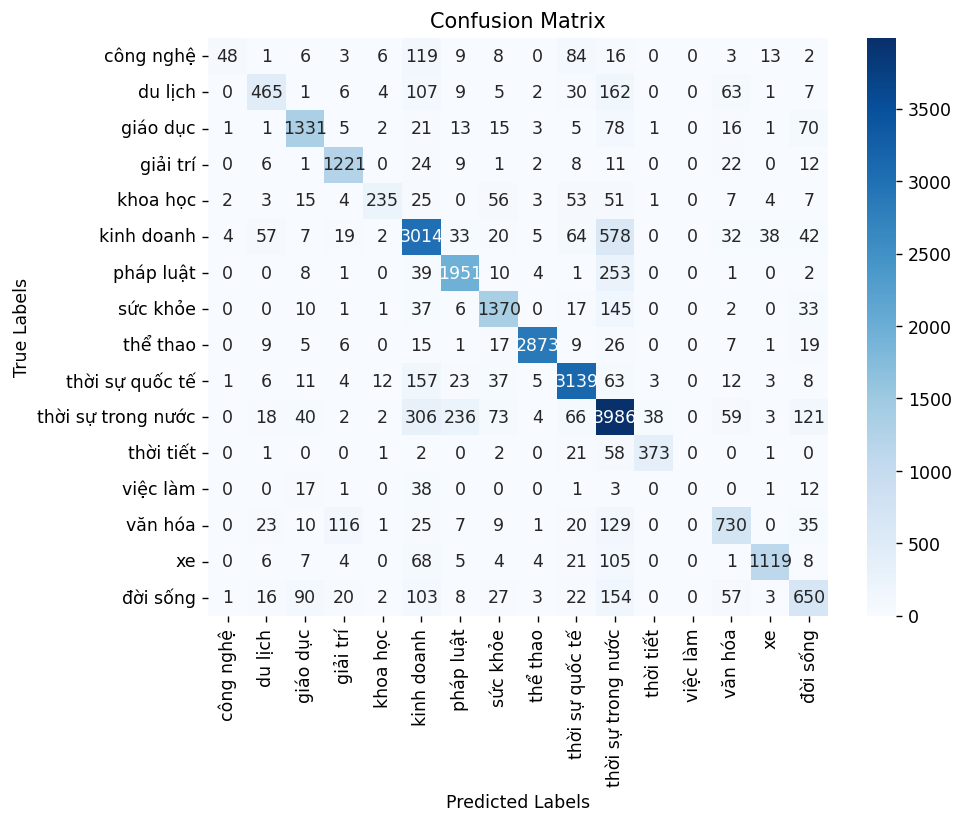

In [86]:
cm = confusion_matrix(val_y_sr, nb.predict(val_X_tfidf))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()

In [90]:
%%time
# Logistic Regression
log_reg_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=0)
log_reg_model.fit(train_X_tfidf,train_y_sr)

CPU times: total: 37 s
Wall time: 43.4 s


LogisticRegression(max_iter=1000, random_state=0)

In [91]:
# Lưu lại model
filename = 'log_reg_model.sav'
pickle.dump(log_reg_model, open(pickle_dir + filename, 'wb'))

In [92]:
log_reg_model.score(train_X_tfidf,train_y_sr)

0.8871398365825688

In [93]:
prediction=log_reg_model.predict(val_X_tfidf)
1 - (prediction != val_y_sr).mean()

0.8514603117720838

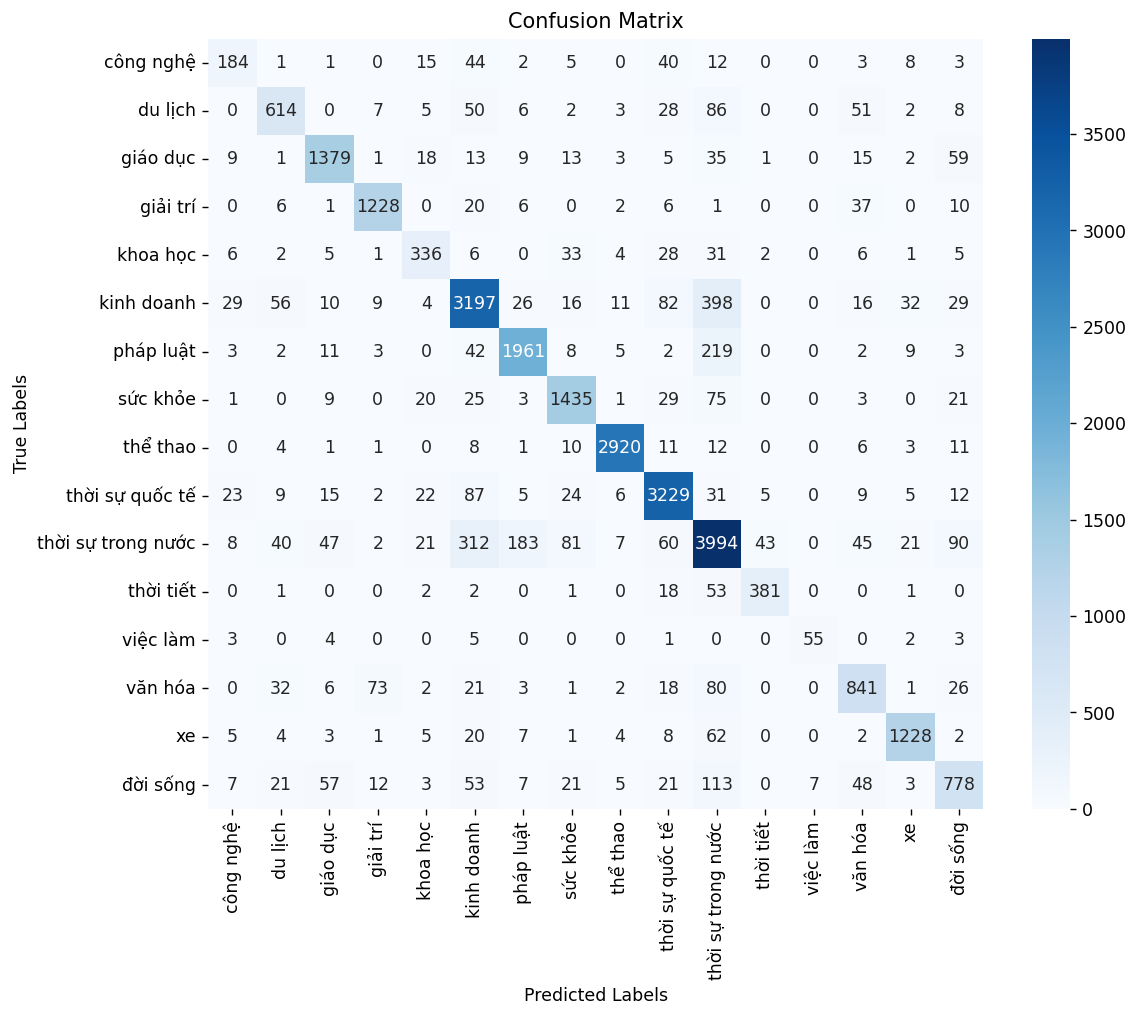

In [95]:
cm = confusion_matrix(val_y_sr, log_reg_model.predict(val_X_tfidf))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation='vertical')
plt.show()

In [96]:
%%time
# Neuron network
mlp_model = MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500)
mlp_model.fit(train_X_tfidf,train_y_sr)

CPU times: total: 3min 10s
Wall time: 3min 40s


MLPClassifier(activation='tanh', hidden_layer_sizes=20, max_iter=2500,
              random_state=0, solver='lbfgs')

In [97]:
# Lưu lại model
filename = 'mlp_model.sav'
pickle.dump(mlp_model, open(pickle_dir + filename, 'wb'))

In [98]:
mlp_model.score(train_X_tfidf,train_y_sr)

0.9999014478211009

In [99]:
prediction=mlp_model.predict(val_X_tfidf)
1 - (prediction != val_y_sr).mean()

0.8172728901630533

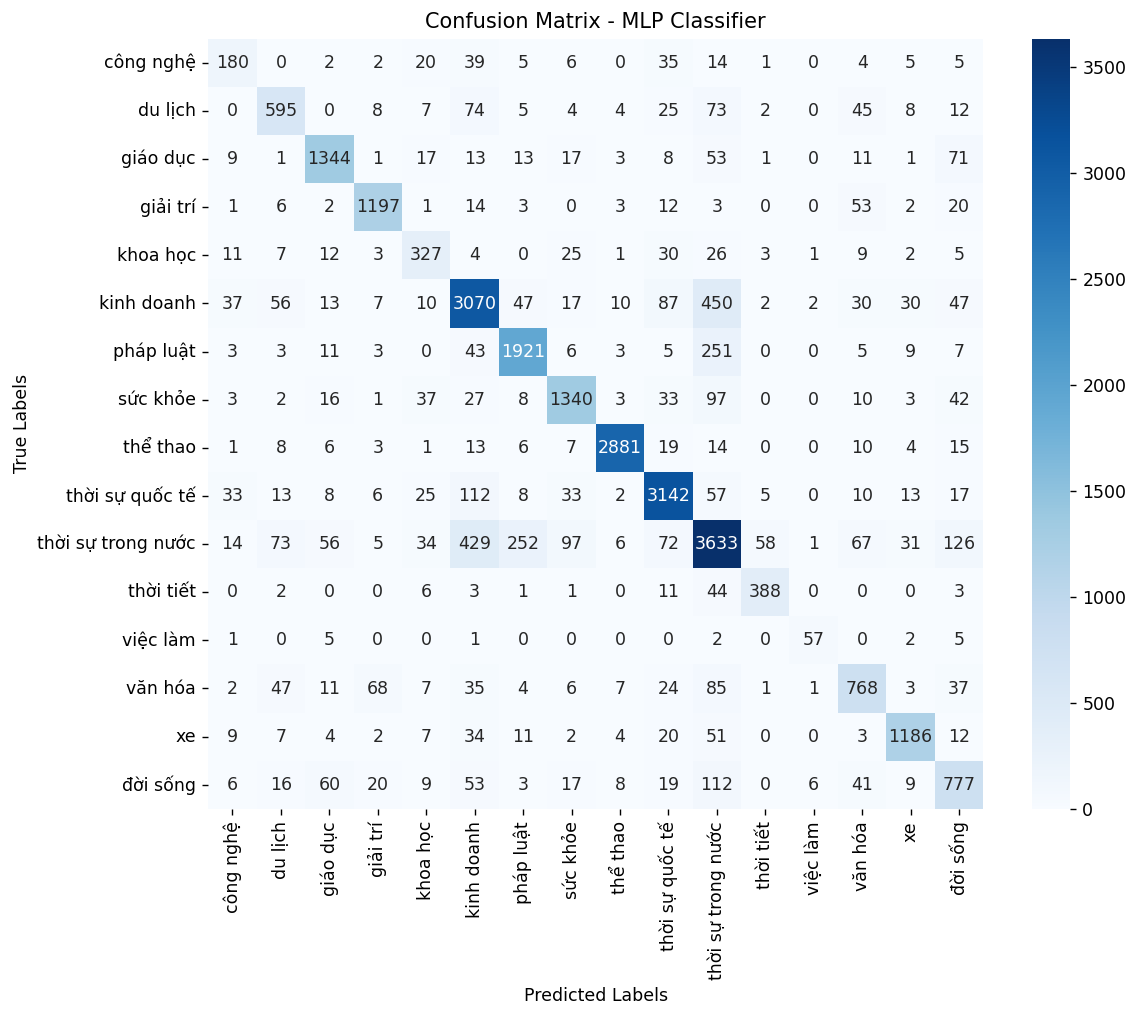

In [102]:
cm = confusion_matrix(val_y_sr, mlp_model.predict(val_X_tfidf))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MLP Classifier')
plt.xticks(rotation='vertical')
plt.show()

In [103]:
%%time
# Neuron network (sử dụng kỹ thuật bagging)
n_estimators = 10
mlp_bag_model = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500), n_estimators = n_estimators, max_samples=5000, random_state=0)
mlp_bag_model.fit(train_X_tfidf,train_y_sr)

CPU times: total: 36.7 s
Wall time: 50.8 s


BaggingClassifier(estimator=MLPClassifier(activation='tanh',
                                          hidden_layer_sizes=20, max_iter=2500,
                                          random_state=0, solver='lbfgs'),
                  max_samples=5000, random_state=0)

In [104]:
# Lưu lại model
filename = 'mlp_bag_model.sav'
pickle.dump(mlp_bag_model, open(pickle_dir + filename, 'wb'))

In [105]:
mlp_bag_model.score(train_X_tfidf,train_y_sr)

0.8470111811926605

In [106]:
prediction=mlp_bag_model.predict(val_X_tfidf)
1 - (prediction != val_y_sr).mean()

0.8340082422504927

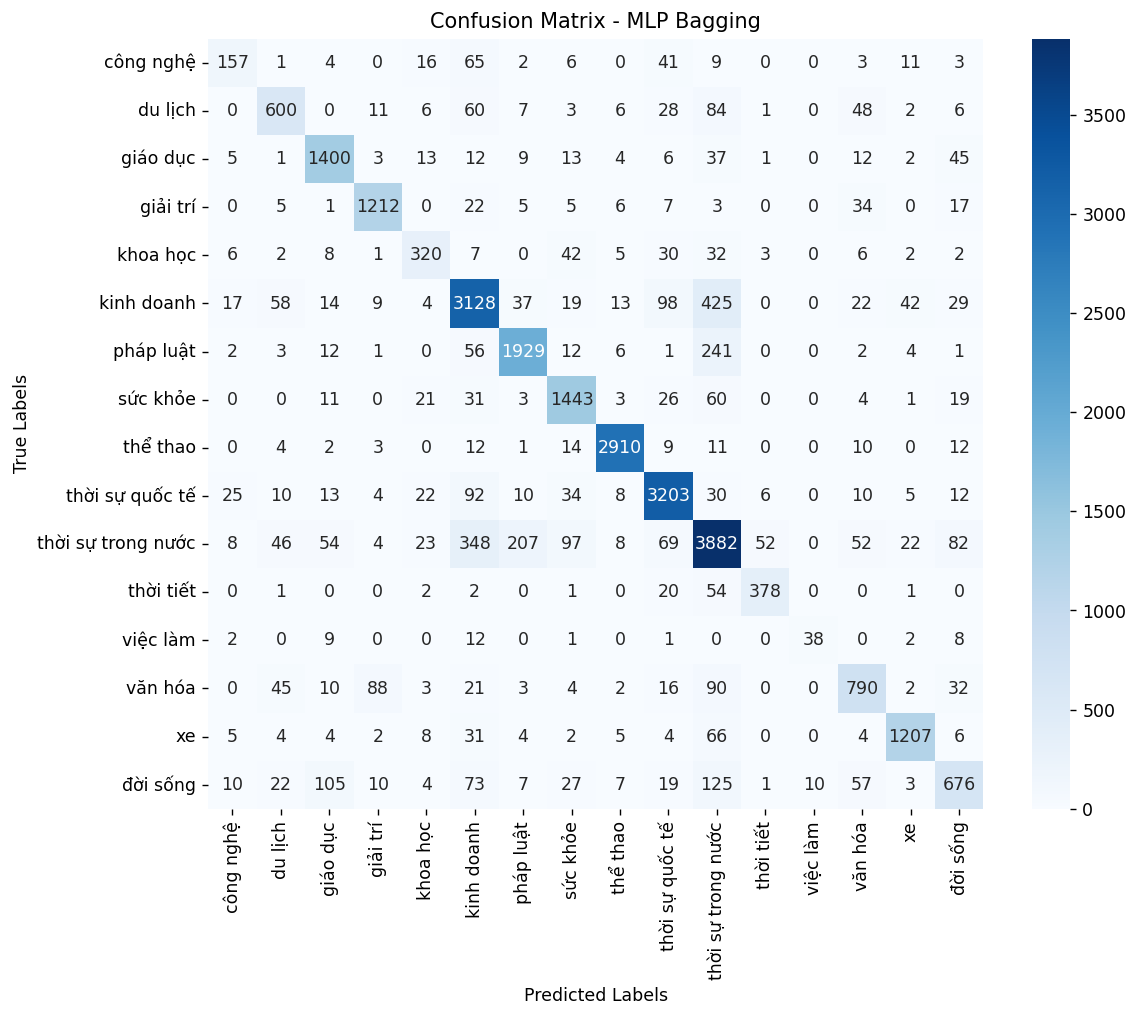

In [107]:
cm = confusion_matrix(val_y_sr, mlp_bag_model.predict(val_X_tfidf))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MLP Bagging')
plt.xticks(rotation='vertical')
plt.show()